# Exploratory: relationship between votes and seats

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Do-primary-votes-for-Others-follow-the-cube-rule?" data-toc-modified-id="Do-primary-votes-for-Others-follow-the-cube-rule?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do primary votes for Others follow the cube rule?</a></span></li><li><span><a href="#Cube-rule-and-2pp-vs-seats-won-by-major-parties-only-(ie.-ignoring-other-seats-won)" data-toc-modified-id="Cube-rule-and-2pp-vs-seats-won-by-major-parties-only-(ie.-ignoring-other-seats-won)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cube rule and 2pp vs seats won by major parties only (ie. ignoring other seats won)</a></span></li><li><span><a href="#2pp-margin-vs-seat-margin" data-toc-modified-id="2pp-margin-vs-seat-margin-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>2pp margin vs seat margin</a></span></li></ul></div>

## Python setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import bs4

import platform, pathlib

In [2]:
print(f'python { platform.python_version()}')
print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'matplotlib {mpl.__version__}')
print(f'requests {requests.__version__}')
print(f'bs4 {bs4.__version__}')


python 3.9.7
numpy 1.21.4
pandas 1.3.4
matplotlib 3.4.3
requests 2.26.0
bs4 4.10.0


In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

## Get the data

In [4]:
def get_wiki_page():
    WIKIURL = 'https://en.wikipedia.org/wiki/List_of_Australian_federal_elections'
    response = requests.get(WIKIURL)
    assert(response.status_code == 200) # successful retrieval
    return response.text
    
text = get_wiki_page()
source = 'Election data sourced from Wikipedia'

In [5]:
# get data into a DataFrame
HISTORY_TABLE = 2
soup = bs4.BeautifulSoup(text)
tables = soup.findAll('table')
html = str(tables[HISTORY_TABLE])
df = pd.read_html(html, flavor='bs4', na_values='–')[0]
df = df.dropna(axis=0, how='any')

# fix the date column to a pandas Timestamp
for i, name in enumerate(['Date', '']):
    # kludge for df.rename() not working with multi-indexes
    df.rename(columns={(df.columns[0])[i]: (name),}, level=i, inplace=True)
df['Date'] = df['Date'].str.replace(' election', '').str.strip()
df['Date'] = pd.to_datetime(df['Date'])


# fix percentages - make numerical columns a numerical dtype
for c in df.select_dtypes(include=['string','object']).columns:
    df[c] = df[c].str.replace('%', '').astype(float) / 100.0
df

Date Primary vote               2PP vote        Seats              \
                       ALP   L+NP   Oth.      ALP   L+NP   ALP  L+NP  Oth.   
5  1919-12-13        0.425  0.543  0.032    0.459  0.541  25.0  38.0   2.0   
6  1922-12-16        0.423  0.478  0.099    0.488  0.512  29.0  40.0   6.0   
7  1925-11-14        0.450  0.532  0.018    0.462  0.538  23.0  50.0   2.0   
8  1928-11-17        0.446  0.496  0.058    0.484  0.516  31.0  42.0   2.0   
9  1929-10-12        0.488  0.442  0.070    0.567  0.433  46.0  24.0   5.0   
10 1931-12-19        0.271  0.484  0.245    0.415  0.585  14.0  50.0  11.0   
11 1934-09-15        0.268  0.456  0.276    0.465  0.535  18.0  42.0  14.0   
12 1937-10-23        0.432  0.493  0.075    0.494  0.506  29.0  43.0   2.0   
13 1940-09-21        0.402  0.439  0.159    0.503  0.497  32.0  36.0   6.0   
14 1943-08-21        0.499  0.230  0.271    0.582  0.418  49.0  19.0   6.0   
15 1946-09-28        0.497  0.393  0.110    0.541  0.459  43.0  26.0   5.0   
16 1949-12-10        0.460  0.503  0.037    0.490  0.510  47.0  74.0   0.0   
17 1951-04-28        0.476  0.503  0.021    0.493  0.507  52.0  69.0   0.0   
18 1954-05-29        0.500  0.468  0.032    0.507  0.493  57.0  64.0   0.0   
19 1955-12-10        0.446  0.476  0.078    0.458  0.542  47.0  75.0   0.0   
20 1958-11-22        0.428  0.466  0.106    0.459  0.541  45.0  77.0   0.0   
21 1961-12-09        0.479  0.421  0.100    0.505  0.495  60.0  62.0   0.0   
22 1963-11-30        0.455  0.460  0.085    0.474  0.526  50.0  72.0   0.0   
23 1966-11-26        0.400  0.500  0.100    0.431  0.569  41.0  82.0   1.0   
24 1969-10-25        0.470  0.433  0.097    0.502  0.498  59.0  66.0   0.0   
25 1972-12-02        0.496  0.415  0.089    0.527  0.473  67.0  58.0   0.0   
26 1974-05-18        0.493  0.449  0.058    0.517  0.483  66.0  61.0   0.0   
27 1975-12-13        0.428  0.531  0.041    0.443  0.557  36.0  91.0   0.0   
28 1977-12-10        0.397  0.481  0.122    0.454  0.546  38.0  86.0   0.0   
29 1980-10-18        0.452  0.463  0.085    0.496  0.504  51.0  74.0   0.0   
30 1983-03-05        0.495  0.436  0.069    0.532  0.468  75.0  50.0   0.0   
31 1984-12-01        0.476  0.450  0.074    0.518  0.482  82.0  66.0   0.0   
32 1987-07-11        0.458  0.461  0.081    0.508  0.492  86.0  62.0   0.0   
33 1990-03-24        0.394  0.435  0.171    0.499  0.501  78.0  69.0   1.0   
34 1993-03-13        0.449  0.443  0.107    0.514  0.486  80.0  65.0   2.0   
35 1996-03-02        0.387  0.473  0.140    0.464  0.536  49.0  94.0   5.0   
36 1998-10-03        0.401  0.395  0.204    0.510  0.490  67.0  80.0   1.0   
37 2001-11-10        0.378  0.430  0.192    0.490  0.510  65.0  82.0   3.0   
38 2004-10-09        0.376  0.467  0.157    0.473  0.527  60.0  87.0   3.0   
39 2007-11-24        0.434  0.421  0.145    0.527  0.473  83.0  65.0   2.0   
40 2010-08-21        0.380  0.433  0.187    0.501  0.499  72.0  72.0   6.0   
41 2013-09-07        0.334  0.456  0.210    0.465  0.535  55.0  90.0   5.0   
42 2016-07-02        0.347  0.420  0.233    0.496  0.504  69.0  76.0   5.0   
43 2019-05-18        0.333  0.414  0.253    0.485  0.515  68.0  77.0   6.0   

           
    Total  
5    75.0  
6    75.0  
7    75.0  
8    75.0  
9    75.0  
10   75.0  
11   74.0  
12   74.0  
13   74.0  
14   74.0  
15   74.0  
16  121.0  
17  121.0  
18  121.0  
19  122.0  
20  122.0  
21  122.0  
22  122.0  
23  124.0  
24  125.0  
25  125.0  
26  127.0  
27  127.0  
28  124.0  
29  125.0  
30  125.0  
31  148.0  
32  148.0  
33  148.0  
34  147.0  
35  148.0  
36  148.0  
37  150.0  
38  150.0  
39  150.0  
40  150.0  
41  150.0  
42  150.0  
43  151.0

In [6]:
def get_recent_data(year='1919'):
    rdf = df[df['Date'] > pd.Timestamp(f'{year}-01-01')].copy()
    rdf.index = rdf['Date']
    return rdf
    
rdf = get_recent_data()

In [7]:
def plot_results(seats_won_share, cubed_vote_share, 
                 title, xlabel, ylabel, annotate_cubic=True):
    
    # quick linear regression
    m,b = np.polyfit(cubed_vote_share, seats_won_share, 1)
    r_squared = np.corrcoef(cubed_vote_share, seats_won_share)[0,1] ** 2
    
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.margins(0.025)
    ax.scatter(x=cubed_vote_share, y=seats_won_share)
    for k in seats_won_share.index:
        ax.text(cubed_vote_share[k], seats_won_share[k], k.year)
    
    ax.plot(cubed_vote_share, m * cubed_vote_share + b, lw=1, c='blue')
    fig.text (0.005, 0.005, f'$y = {round(m, 3)}x + {round(b, 3)}$; ($R^2={r_squared.round(3)}$)',
              ha='left', va='bottom', fontsize=9)
    fig.text (0.995, 0.005, source,
              ha='right', va='bottom', c='#999999', fontsize=8)
    
    # annotate vote shares
    if annotate_cubic:
        annotations = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 
                       0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        for point in annotations:
            cubed = point ** 3
            if xlim[0] < cubed < xlim[1]:
                ax.axvline(cubed, c='#555555', lw=0.5)
                ax.text(cubed, ylim[0], f'{int(point * 100)}%', ha='left', va='bottom')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout(pad=1.1)

    fig.savefig(CHART_DIR+title+'.png', dpi=300)
    plt.show()
    plt.close()  

## Do primary votes for Others follow the cube rule?

Short answer: Not sufficiently enough

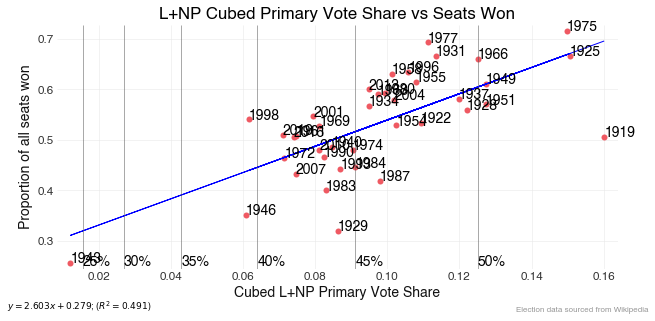

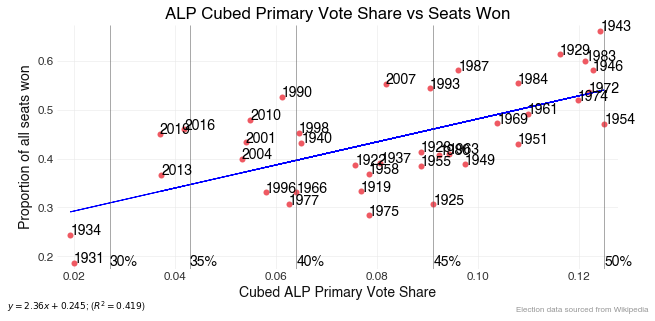

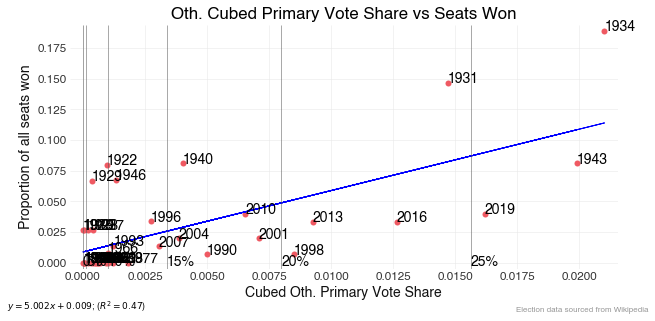

In [8]:
rdf = get_recent_data()
ylabel = 'Proportion of all seats won'
for party in ('L+NP', 'ALP', 'Oth.'):

    seats_won_share = rdf[('Seats', party)] / rdf[('Seats', 'Total')]
    cubed_vote_share = rdf[('Primary vote', party)] ** 3
    title = f'{party} Cubed Primary Vote Share vs Seats Won'
    xlabel = f'Cubed {party} Primary Vote Share'
    plot_results(seats_won_share, cubed_vote_share, title, xlabel, ylabel)

## Cube rule and 2pp vs seats won by major parties only (ie. ignoring other seats won)

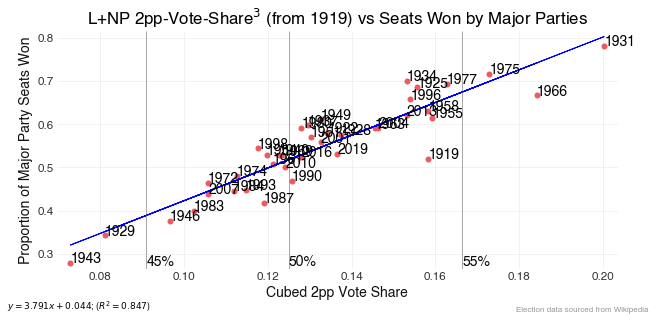

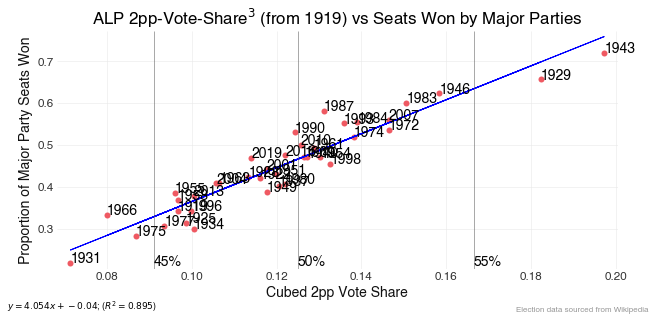

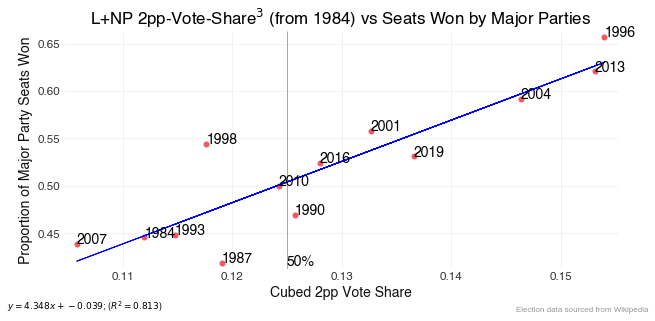

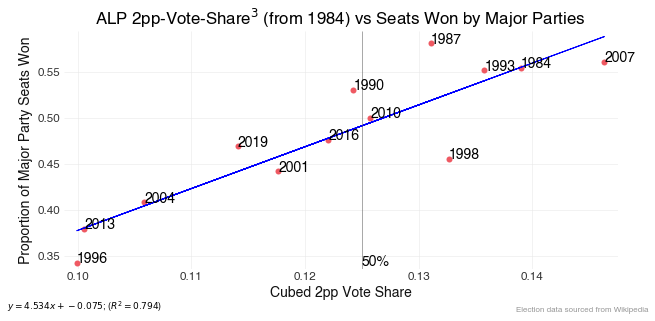

In [9]:
parties = ['L+NP', 'ALP']
rdf = get_recent_data()
ylabel = 'Proportion of Major Party Seats Won'
xlabel = 'Cubed 2pp Vote Share'

for year in ['1919', '1984']:
    rdf = get_recent_data(year)
    for party in parties:
        seats_won_share = rdf[('Seats', party)] / ( rdf[('Seats', 'Total')] - rdf[('Seats', 'Oth.')])
        cubed_vote_share = rdf[('2PP vote', party)] ** 3
        title = f'{party} 2pp-Vote-Share$^3$ (from {year}) vs Seats Won by Major Parties'
        plot_results(seats_won_share, cubed_vote_share, title, xlabel, ylabel)

## 2pp margin vs seat margin

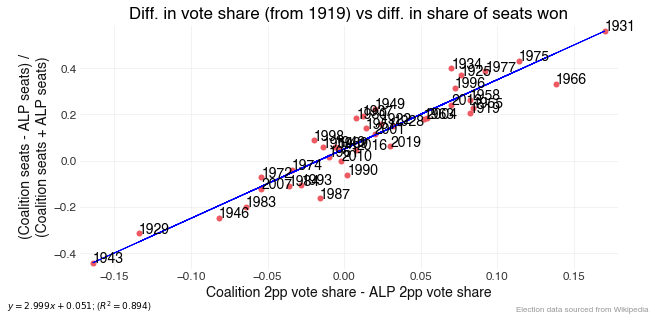

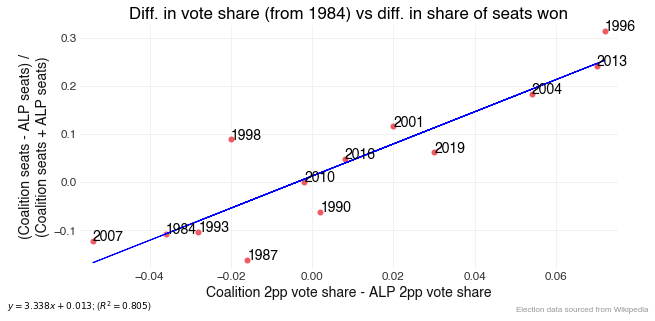

In [10]:
for year in ['1919', '1984']:
    rdf = get_recent_data(year)
    seat_diff = (
        (rdf[('Seats', 'L+NP')] - rdf[('Seats', 'ALP')]) 
        / (rdf[('Seats', 'L+NP')] + rdf[('Seats', 'ALP')])
    )
    party_diff = rdf[('2PP vote', 'L+NP')] - rdf[('2PP vote', 'ALP')]

    title = f'Diff. in vote share (from {year}) vs diff. in share of seats won'
    xlabel = 'Coalition 2pp vote share - ALP 2pp vote share'
    ylabel = '(Coalition seats - ALP seats) /\n(Coalition seats + ALP seats)'
    plot_results(seat_diff, party_diff, title, xlabel, ylabel, False)